# Propensity Modeling

In [19]:
import numpy as np
import pandas as pd
import pickle
# import urllib
# from tqdm import tqdm, trange, tqdm_pandas
# import os
# from user_agents import parse
# import datetime
import time
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import grid_search, cross_validation

from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import cycle
# pd.set_option('display.max_columns', 1000)

##  1. Data

In [20]:
%%time
with open("../Data/Feature_Engineering/df_features_normalize.p", "rb" ) as f:
    data_features = pickle.load(f)    
with open( "../Data/Feature_Engineering/df_label.p", "rb" ) as f:
    data_label = pickle.load(f)

CPU times: user 550 ms, sys: 13.5 s, total: 14 s
Wall time: 1min 37s


In [21]:
%%time
X = data_features
Y = data_label

CPU times: user 0 ns, sys: 140 ms, total: 140 ms
Wall time: 151 ms


### 1.1 Split data to training set, validation set and test set

In [22]:
print(X.shape)
bar_80 = np.floor(X.shape[0]*0.8).astype(int)
bar_80=bar_80+1
bar_80

(220047, 2357)


176038

In [23]:
X_train=X[:bar_80]
Y_train=Y[:bar_80]
X_test=X[bar_80:]
Y_test=Y[bar_80:]

## 2.0 Feature Selection

In [24]:
%%time
clf=RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
                           oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
                           class_weight=None)

clf.fit(X_train, Y_train)

clf.feature_importances_ 

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(220047, 79)
CPU times: user 33.8 s, sys: 699 ms, total: 34.5 s
Wall time: 13.3 s


In [25]:
X_train=X_new[:bar_80]
Y_train=Y[:bar_80]
X_test=X_new[bar_80:]
Y_test=Y[bar_80:]

## 2. Adaboost Classifier


|  Parameters  |  Explanation |  
|---|---|---|---|---|
|  n_estimators | The number of trees in the forest  |   
| criterion  | The function to measure the quality of a split.  |   
|  max_depth | The number of features to consider when looking for the best split  |   
|  max_depth | The maximum depth of the tree.  |   
|  min_samples_split |   |  
| min_samples_leaf  |   |  
| max_features  |   |  
| max_leaf_nodes  |   |   
| bootstrap  |   |   
| oob_score  |   |   
|  n_jobs |   |   
|  random_state |   |   
|  verbose |   |  
|  warm_start |   |   
|  class_weight |   |   




In [26]:
%%time
clf=AdaBoostClassifier()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 63.6 ms


In [28]:
# %%time
# gs = grid_search.GridSearchCV(
# estimator = clf(class_weight=None, max_iter=10000, penalty='l2'),
# param_grid ={'C': [10**-i for i in range(-2, 3)]},
# cv=cross_validation.KFold(n=len(Y_train), n_folds=10))

In [27]:
%%time
clf.fit(X_train, Y_train)

CPU times: user 14.8 s, sys: 251 ms, total: 15.1 s
Wall time: 15.8 s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

### 2.1 Save Model

In [9]:
%%time
path = '../Data/Propensity_Modeling/Adaboost.pkl'
joblib.dump(clf, path)

# clf=RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
#                            min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
#                            oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
#                            class_weight=None)

CPU times: user 140 ms, sys: 319 ms, total: 459 ms
Wall time: 3.71 s


In [32]:
Y_predict=clf.predict(X_test)

### 2.2 Load Model

In [10]:
%%time
# load the model from disk
path = '../Data/Propensity_Modeling/Adaboost.pkl'
Random_Forest_Classifier = joblib.load(path)

# result = loaded_model.score(X_test, Y_test)
# print(result)

CPU times: user 130 ms, sys: 437 ms, total: 567 ms
Wall time: 567 ms


## 3. Result Analysis

### 3.1 Accuracy Rate

In [29]:
# with feature selection:
%%time
Y_pred = clf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.923333863528
CPU times: user 709 ms, sys: 7 ms, total: 716 ms
Wall time: 1.84 s


In [11]:
# # without feature selection
# %%time
# Y_pred = clf.predict(X_test)
# print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.922924856279
CPU times: user 3.88 s, sys: 150 ms, total: 4.03 s
Wall time: 4.03 s


In [30]:
# Result with 100 trees
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96     37065
          1       0.83      0.64      0.73      6944

avg / total       0.92      0.92      0.92     44009



In [31]:
1-sum(Y_test)/len(Y_test)

0.84221409257197388

### 3.2 Confusion matrix

In [32]:
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix is:
 [[36166   899]
 [ 2475  4469]]

Plot of Confusion Matrix is:


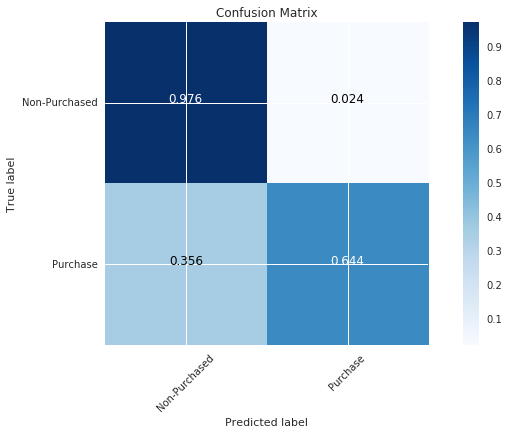

In [33]:
Y_pred = clf.predict(X_test)
# cfm = confusion_matrix(y_true, y_pred, labels
cfm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])
print('Confusion Matrix is:\n',confusion_matrix(Y_test, Y_pred))
print('\nPlot of Confusion Matrix is:')
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["Non-Purchased", "Purchase"], normalize=True)

**feature Importance check**

In [34]:
clf.feature_importances_

array([ 0.02,  0.  ,  0.06,  0.  ,  0.  ,  0.  ,  0.08,  0.04,  0.16,
        0.1 ,  0.  ,  0.1 ,  0.02,  0.1 ,  0.04,  0.06,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.06,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.02,  0.  ,
        0.  ,  0.  ,  0.  ,  0.02,  0.02,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.08,  0.02,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

### 3.3 ROC 

In [94]:
Y_prob = clf.predict_proba(X_test) 
# 1st column is label 0 and 2nd column is label 1.

fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc= auc(fpr, tpr)

In [95]:
print(Y_test.shape)
print(Y_pred.shape)

(44009,)
(44009,)


In [96]:
Y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [97]:
Y_prob

array([[ 0.53008127,  0.46991873],
       [ 0.52881387,  0.47118613],
       [ 0.52576568,  0.47423432],
       ..., 
       [ 0.51539571,  0.48460429],
       [ 0.51708714,  0.48291286],
       [ 0.52778641,  0.47221359]])

In [89]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_prob[:,0], pos_label=2)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [90]:
fpr

array([  0.00000000e+00,   2.27226249e-05,   6.81678748e-05, ...,
         9.99931832e-01,   9.99977277e-01,   1.00000000e+00])

In [76]:
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)

In [77]:
fpr

array([ 0. ,  0.5,  0.5,  1. ])

In [101]:
n_class=0
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, Y_prob[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_prob[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

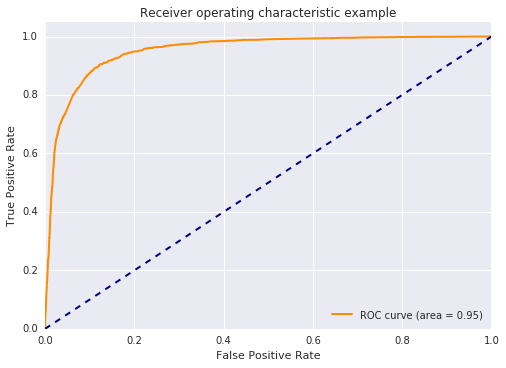

In [103]:
# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

---